# **Final Project: Housing Prices**

Prices Data Source: https://www.zillow.com/research/data/

Housing Data Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

from scipy import stats
from sklearn.linear_model import LinearRegression


# Data Load & Preprocessing

In [ ]:
prices = pd.read_csv('/content/drive/MyDrive/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month-2.csv')
print(prices.head())

   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31  \
0    102001         0    United States    country       NaN  120033.213118   
1    394913         1     New York, NY        msa        NY  214314.541751   
2    753899         2  Los Angeles, CA        msa        CA  225004.543761   
3    394463         3      Chicago, IL        msa        IL  149670.248748   
4    394514         4       Dallas, TX        msa        TX  125827.184072   

      2000-02-29     2000-03-31     2000-04-30     2000-05-31  ...  \
0  120244.390020  120506.280472  121067.984085  121714.437600  ...   
1  215225.257633  216144.408385  218006.963476  219935.703774  ...   
2  225841.846147  226957.124939  229176.155088  231603.078401  ...   
3  149808.799798  150072.672713  150729.122949  151518.753624  ...   
4  125883.227939  125947.656102  126114.969273  126335.567108  ...   

      2023-05-31     2023-06-30     2023-07-31     2023-08-31     2023-09-30  \
0  338064.442178  339983.42982

I loaded in the CSV file from Zillow into the prices datadframe. This dataset is time series data on various cities/regions in the United States. The data is tracking the median price of a home from 2000 to 2024 with the time steps being 1 month. Each row is a different city with prices data, region name, region type, and state name.


In [ ]:
print(prices[prices['StateName'] == 'IA']['RegionName'])
prices = prices[prices['RegionName'] == 'Ames, IA']

82       Des Moines, IA
175    Cedar Rapids, IA
244       Iowa City, IA
253        Waterloo, IA
288      Sioux City, IA
326            Ames, IA
384         Dubuque, IA
531    Fort Madison, IA
580      Mason City, IA
613         Clinton, IA
631      Burlington, IA
651       Muscatine, IA
677    Marshalltown, IA
739         Ottumwa, IA
850       Oskaloosa, IA
865      Storm Lake, IA
878     Spirit Lake, IA
884         Spencer, IA
886       Fairfield, IA
Name: RegionName, dtype: object


Then I queried for the cities within Iowa to see which cities we had time series data on. Since the other dataset was using the Ames, Iowa housing data I intended to use whatever reference city was closest. However since Ames, Iowa was a row in the dataframe I grabbed that series of pricing data and stored in prices.

In [ ]:
#Run only once or will overwrite data
first_date = prices.iloc[:, 7:].dropna(axis=1).columns[0]
print(first_date)

prices = prices.loc[:, first_date:]
print(prices)

2009-03-31
        2009-03-31     2009-04-30    2009-05-31     2009-06-30     2009-07-31  \
326  140301.855022  140275.166234  140153.94977  139969.341729  139803.520647   

        2009-08-31     2009-09-30     2009-10-31     2009-11-30  \
326  139739.578968  139620.654308  139383.759876  139122.646758   

        2009-12-31  ...     2023-05-31     2023-06-30     2023-07-31  \
326  138899.948621  ...  238842.468771  240855.633292  242203.790851   

        2023-08-31     2023-09-30     2023-10-31     2023-11-30  \
326  243012.143392  243184.165015  242911.011567  242201.591237   

        2023-12-31     2024-01-31     2024-02-29  
326  241087.867471  239796.689795  239075.438255  

[1 rows x 180 columns]


This series had a alot of missing price values at the beginnning as Zillow had no data on Ames, Iowa then. In order to restrict this I grabbed the date of the first non NaN value which was 2009-03-31. Then I only grabbed the values after that first_data and stored it in prices. The final data was a series of 180 median home prices in Ames recorded since 2009.

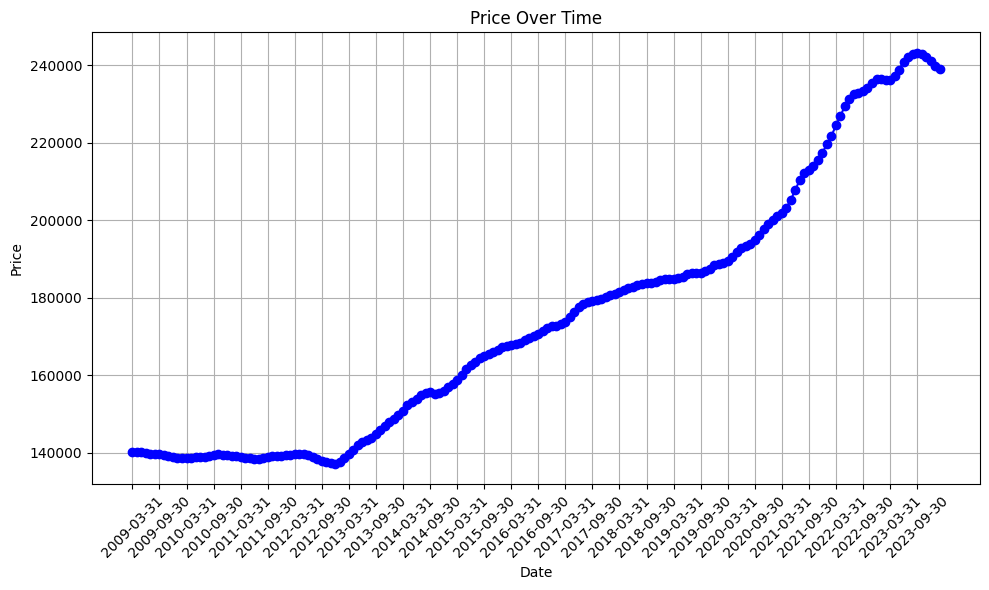

In [ ]:
from matplotlib.dates import MonthLocator, DateFormatter

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(prices.columns, prices.iloc[0], marker='o', linestyle='-', color='b')

# Customize plot labels and title
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Manually set x-axis ticks to show every Nth date (e.g., every 6 months)
# Replace N with the desired interval (e.g., 6 for every 6 months)
N = 6
plt.xticks(prices.columns[::N], rotation=45)  # Show every Nth date and rotate labels

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df_housing = pd.read_csv('/content/drive/MyDrive/train.csv')
print(df_housing)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

Loaded in the second dataset that contained alot of the primary data for houses in Ames, Iowa. The dataset contained 1460 entries of homes in Ames, Iowa with 81 feature columns of data recorded for each.

In [ ]:
def get_median_price(row):
    year_sold = row['YrSold']
    key = str(year_sold) + "-12-31"
    return prices[key]

df_housing = df_housing[df_housing['YrSold'] >= 2009]
df_housing['median_price'] = df_housing.apply(get_median_price, axis=1)
df_housing['diff_price'] = df_housing['SalePrice'] - df_housing['median_price']

Restricted the df_housing dataset to only include homes that were sold after 2009 to ensure that I had the appropriate time series data in the prices variables. Alongside this I grabbed the median sale price from the prices dataset and added it as a column for the df_housing to aggregate starting price data. Then as a reference variable I created a column to be the difference in the median price and the actual price.

**Missing Data**

In [ ]:
rows = df_housing.shape[0]
counts = df_housing.count()
print("Entries: ", rows)
print(counts[counts < rows])
counts = counts[counts < rows]

Entries:  513
LotFrontage     416
Alley            26
MasVnrType      204
MasVnrArea      511
BsmtQual        495
BsmtCond        495
BsmtExposure    495
BsmtFinType1    495
BsmtFinType2    494
FireplaceQu     261
GarageType      487
GarageYrBlt     487
GarageFinish    487
GarageQual      487
GarageCond      487
PoolQC            0
Fence           107
MiscFeature      25
dtype: int64


These are the columns within the dataframe that contain NaN values for some of its rows. The number next to the value is the amount of rows for which the column has a value, it should be 513.

In order to ease the cleansing process, I removed any variables that were missing more than 50% of its values for the homes.

In [ ]:
columns_to_drop = counts[counts < (rows * .5)].index
print(columns_to_drop)
df_housing.drop(columns_to_drop, axis=1, inplace=True)


Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


The rows in our dataset with missing values have missing column data for all related columns(ex: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1). As rows missing one of these variables data will miss all of them. Since the missing data is largely in the same rows we can just drop these rows.


In [ ]:
conditions = counts[counts > 450].index
print(df_housing.shape)

(513, 78)


Entries:  468
LotFrontage    376
FireplaceQu    252
dtype: int64
468


HOT DECK IMPUTATION


In [ ]:
print(df_housing.shape)

(468, 78)


After we have completed pre-processing our data we have 468 rows of home data in Ames, Iowa and 79 variables(columns) of data to describe each home.

DELETE

 You must present three conclusions using at least three different statistical
methods including hypothesis testing.
■ For example: What are the main characteristics of your dataset? How
many features and entries are there? Is a feature over-represented? Are features correlated? Are there outliers? Identify the attributes that will affect your choice of primary analysis technique. Etcetera.
○ For each method, you must have at least one gorgeous plot.

## One Hot Encoding

In [22]:
categorical_columns = df_housing.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_columns)


dummies = pd.get_dummies(df_housing[categorical_columns], drop_first=True)
df_numerical = df_housing.drop(categorical_columns, axis=1)
df_encoded = pd.concat([df_numerical, dummies], axis=1)
print(df_encoded.columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_WD', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=211)


# Preventing Multicollinearity


In [24]:
correlation_matrix = df_encoded.drop(['SalePrice', 'median_price', 'diff_price'], axis=1).corr().abs()


highest_corr = (correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                 .stack()
                 .sort_values(ascending=False))

top_corr_pairs = highest_corr.head(10)
print(top_corr_pairs)

Exterior1st_AsphShn  Exterior2nd_AsphShn      1.000000
Exterior1st_CBlock   Exterior2nd_CBlock       1.000000
SaleType_New         SaleCondition_Partial    0.979575
Exterior1st_VinylSd  Exterior2nd_VinylSd      0.970668
Exterior1st_MetalSd  Exterior2nd_MetalSd      0.962943
Exterior1st_CemntBd  Exterior2nd_CmentBd      0.956288
RoofStyle_Gable      RoofStyle_Hip            0.944460
MSZoning_FV          Neighborhood_Somerst     0.937656
GarageQual_TA        GarageCond_TA            0.898761
GarageCars           GarageArea               0.883561
dtype: float64


Lots of perfectly correlated and highly correlated features so we should remove them to improve future model performance

In [ ]:

appearance_count = {}

for (var1, var2) in top_corr_pairs.index:
    if var1 in appearance_count:
        appearance_count[var1] += 1
    else:
        appearance_count[var1] = 1

    if var2 in appearance_count:
        appearance_count[var2] += 1
    else:
        appearance_count[var2] = 1

print(appearance_count)




In [ ]:
processed_df = df_encoded.copy()

variables_to_remove = ['lev', 'valuem','cfp' ]
processed_df = processed_df.drop(variables_to_remove, axis=1)

print(processed_data.shape)

# Data Exploration and Statistical Methods


**Test 1: T test**

H0: The lot size of a house has no effect on its sale price

HA: The lot size of a house has an effect on its sale price

We are using a T Test here as we are attempting to determine the correlation between thhe lot size and sale price variables. Since these are both continuous numerical variables Z test is appropriate to determine if Lot Size affects any of the Sale Price variation.

In [ ]:
ols = smf.ols(formula="SalePrice ~ LotArea", data=df_housing).fit()
print(ols.summary())
p_value = ols.pvalues['LotArea']
print(p_value)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     39.72
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           6.80e-10
Time:                        21:58:57   Log-Likelihood:                -5931.0
No. Observations:                 468   AIC:                         1.187e+04
Df Residuals:                     466   BIC:                         1.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.634e+05   4960.134     32.943      0.0

Based on the results of our T-Test we can reject the null hypothesis, as our P Value for the LotArea coefficient was 6.795310263847286e-10. This value is < .05 so it is statistically significant.

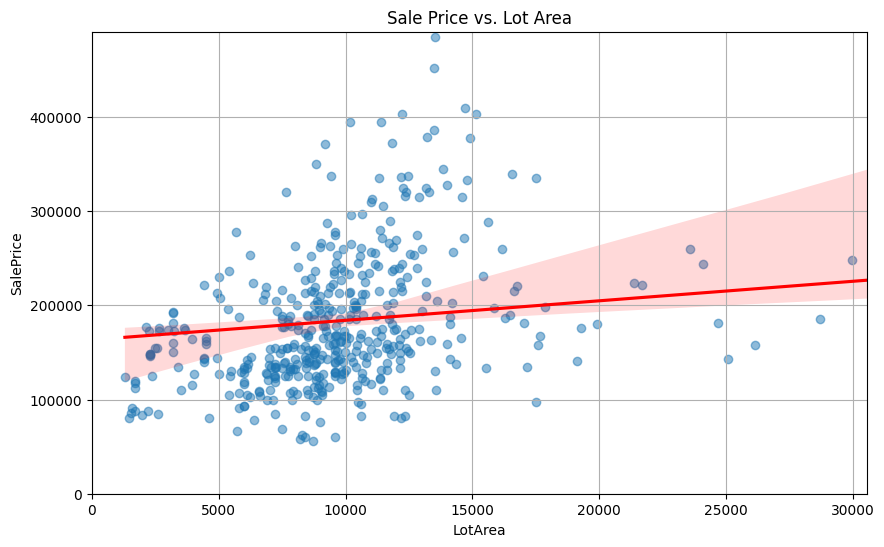

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_housing['LotArea'], df_housing['SalePrice'], alpha=0.5)
plt.title('Sale Price vs. Lot Area')
plt.xlabel('Lot Area(sq feet)')
plt.ylabel('Sale Price($)')

lot_area_limit = (0, df_housing['LotArea'].quantile(0.99))  # Limit to 95th percentile
sale_price_limit = (0, df_housing['SalePrice'].quantile(0.99))

plt.xlim(lot_area_limit)
plt.ylim(sale_price_limit)
sns.regplot(x='LotArea', y='SalePrice', data=df_housing, scatter=False, color='red', label='Fitted line') #

plt.grid(True)
plt.show()

**Test 2: Chi Squared Test**

H0: The neighborhood a house is in has no effect on the type of the building.

HA: The neighborhood a house is in has an effect on the type of the building.


In [ ]:
print(df_housing['Neighborhood'].unique())
print(df_housing['BldgType'].unique())

['Mitchel' 'NWAmes' 'NAmes' 'Sawyer' 'NridgHt' 'CollgCr' 'IDOTRR'
 'Somerst' 'OldTown' 'Gilbert' 'MeadowV' 'Crawfor' 'Edwards' 'SawyerW'
 'Timber' 'BrkSide' 'ClearCr' 'StoneBr' 'NPkVill' 'BrDale' 'Blmngtn'
 'NoRidge' 'SWISU' 'Blueste']
['1Fam' 'TwnhsE' 'Duplex' 'Twnhs' '2fmCon']


Both the the Neighborhood and the BuildingType are categorical variables that in our final analysis can be used as independent variables to predict housing price. In order to determine if there is any correlation between them, and prevent multi-collinearity, I will use a Chi-Squared test.

In [ ]:
contingency_table = pd.crosstab(df_housing['Neighborhood'], df_housing['BldgType'])
res = stats.chi2_contingency(contingency_table)
print("P Value: ", res.pvalue)

P Value:  1.4437154529311824e-45


Based on the results of our Chi Squared Test we can reject the null hypothesis, as our P Value was ~1.44e-45. This value is < .05 so it is statistically significant. This means that statistically the variation in the Building Type can be explained by the Neighborhood the building is in.

Neighborhood
NridgHt    320393.310345
StoneBr    319426.900000
NoRidge    308037.866667
Timber     245330.769231
Somerst    227221.923077
Crawfor    209366.666667
ClearCr    208362.500000
CollgCr    196558.686275
Gilbert    195824.000000
SawyerW    191097.375000
NWAmes     185707.142857
Mitchel    181383.538462
Blmngtn    179266.666667
NAmes      151044.791667
NPkVill    143541.666667
BrkSide    143493.333333
SWISU      141125.818182
Sawyer     136753.458333
Blueste    124000.000000
Edwards    123734.615385
OldTown    122240.558824
BrDale     112500.000000
IDOTRR      98833.625000
MeadowV     85583.333333
Name: SalePrice, dtype: float64


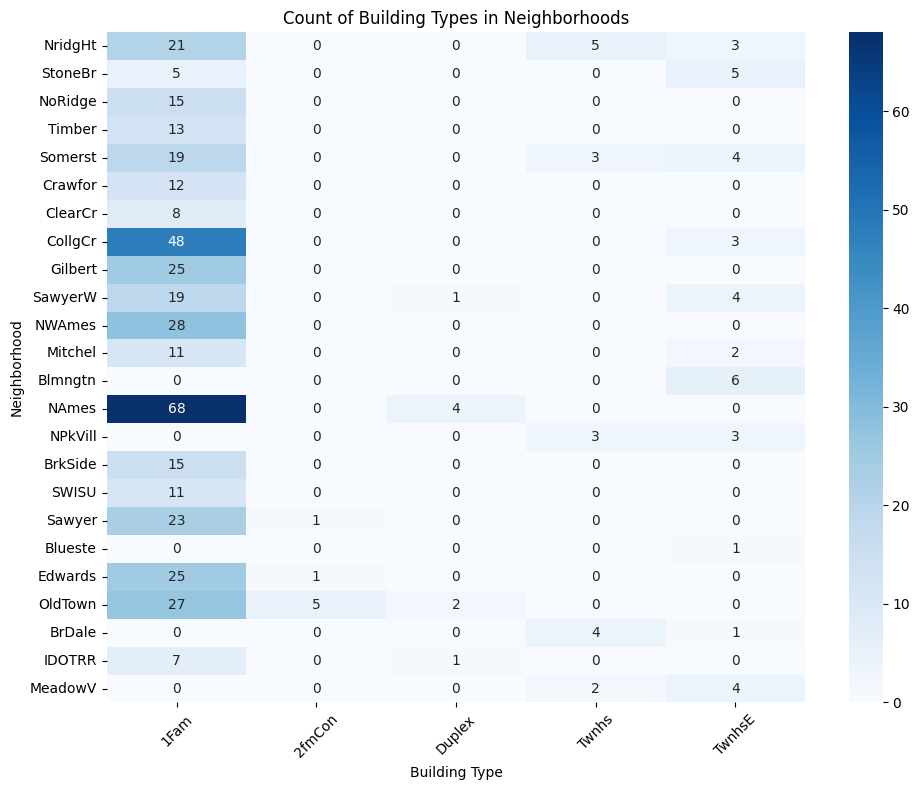

In [ ]:

mean_by_neighborhood = df_housing.groupby('Neighborhood')['SalePrice'].mean()
mean_by_neighborhood = mean_by_neighborhood.sort_values(ascending=False)
print(mean_by_neighborhood)

contingency_table_s = contingency_table.loc[mean_by_neighborhood.index]

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table_s, annot=True, fmt="d", cmap="Blues")
plt.title("Count of Building Types in Neighborhoods")
plt.xlabel("Building Type")
plt.ylabel("Neighborhood")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Test 3: ANOVA Test category**

H0: There is no significant difference in SalePrice among different categories of LandContour.

HA: There is a significant statistical difference in SalePrice among different categories of LandContour.

In [ ]:
print(df_housing['LandContour'].unique())
contour_means = df_housing.groupby('LandContour')['SalePrice'].mean()
print(contour_means)


['Lvl' 'Bnk' 'HLS' 'Low']
LandContour
Bnk    135931.333333
HLS    259627.600000
Low    234960.000000
Lvl    184225.765116
Name: SalePrice, dtype: float64


The LandContour category measures the flatness of a given property by 4 different categories. The categories are Lvl(Leveled), Bnk(Banked), HLS(Hillside), and Low(Depressed). When grabbing the mean of the Sales price for each category, there is difference between the means however for a true test of difference in the categorical variable we need to use ANOVA.

In [ ]:
landcontour_groups = df_housing.groupby('LandContour')['SalePrice'].apply(list)
print(landcontour_groups)
anova_result = stats.f_oneway(*landcontour_groups)
print(anova_result)

LandContour
Bnk    [110000, 140000, 153337, 214500, 110000, 12800...
HLS    [163500, 135000, 224500, 102776, 538000, 20100...
Low    [375000, 260000, 123000, 275000, 316600, 14300...
Lvl    [143000, 200000, 149000, 139000, 154000, 25630...
Name: SalePrice, dtype: object
F_onewayResult(statistic=6.621201592059015, pvalue=0.00021844635253656208)


Based on the results of our ANOVA Test we can reject the null hypothesis, as our P Value was 0.004908. This value is < .05 so it is statistically significant. This tells us that there is some statistical difference in SalePrice across houses with different LandContours.

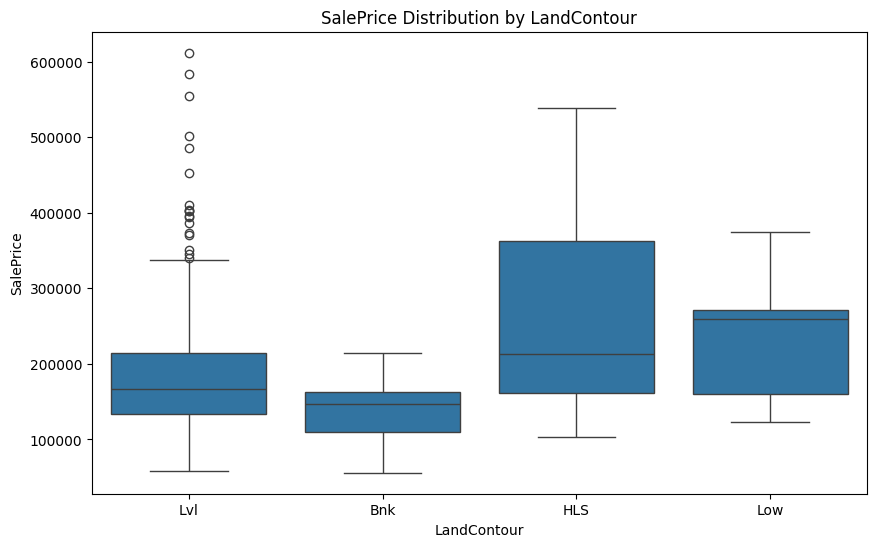

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LandContour', y='SalePrice', data=df_housing)
plt.title('SalePrice Distribution by LandContour')
plt.xlabel('LandContour')
plt.ylabel('SalePrice($)')
plt.show()

The multiple box charts make it evident that the categorical data(Land Countour) has a statistical difference on the SalesPrice. This is clear as the distribution of these values is different and the median price as per the line in the box vary by ~50,000 for each category.

We can also observe here that the HLS land has the widest range in prices as per their 25th and 75th percentile. The banked houses as expected had the lowest house prices as that style of property is generally considered unfavorable.